In [128]:
!pip3 install -U gensim

In [129]:
#Importing warning library to avoid any warnings
import warnings
warnings.filterwarnings('ignore')

In [130]:
import pandas as pd
df=pd.read_csv(r"C:\Users\tribe\OneDrive\Desktop\RatingReview.csv") 
df  #Checking the dataset

,Unnamed: 0,Reviews,Ratings
0,0,Do not buy iphone or expensive product from Am...,1.0 out of 5 stars
1,1,Don’t buy it from this seller,1.0 out of 5 stars
2,2,First Time iPhone User Review :-),5.0 out of 5 stars
3,3,Worst Experience Ever.!,1.0 out of 5 stars
4,4,iPhone 11,1.0 out of 5 stars
...,...,...,...
38433,39279,Good product,5.0 out of 5 stars
38434,39280,Ok,3.0 out of 5 stars
38435,39281,Very good,5.0 out of 5 stars
38436,39282,Nice,5.0 out of 5 stars


In [131]:
#We can see that Unnamed:0 is just the index number.lets drop that column
df.drop('Unnamed: 0',axis=1,inplace=True)

In [132]:
df.shape

(38438, 2)

In [133]:
#Checking for null values 
df.isnull().sum()

Reviews    2
Ratings    0
dtype: int64

In [134]:
#We can handle missing data by filling them with 'No Review' using fillna()
df['Reviews'].fillna('No review',inplace=True)

In [135]:
df.isnull().sum()

Reviews    0
Ratings    0
dtype: int64

In [136]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38438 entries, 0 to 38437
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Reviews  38438 non-null  object
 1   Ratings  38438 non-null  object
dtypes: object(2)
memory usage: 600.7+ KB


In [137]:
l=df['Ratings'].to_list()
li=[]
for i in l:
    li.append(i[0])

In [138]:
df['Ratings']=li

In [139]:
df['Ratings'].unique()

array(['1', '5', '2', '3', '4'], dtype=object)

In [140]:
df.describe()

,Reviews,Ratings
count,38438,38438
unique,21476,5
top,Good,5
freq,1192,15724


In [141]:
#Checking the value counts of the rating
df['Ratings'].value_counts()

5    15724
1     8608
4     7615
3     4120
2     2371
Name: Ratings, dtype: int64

In [142]:
#Importing Matplotlib and Seaborn
import seaborn as sns
import matplotlib.pyplot as plt

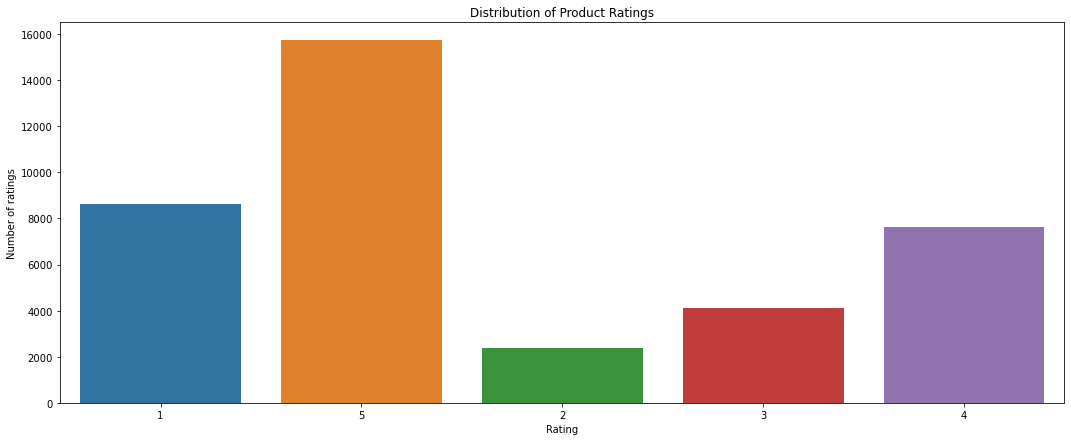

In [143]:
f, axes = plt.subplots(figsize=(18,7))
ax = sns.countplot(x=df['Ratings'])
ax.set(title="Distribution of Product Ratings", xlabel="Rating", ylabel="Number of ratings")
plt.show()

In [144]:
#Importing required libraries
import re # for regex
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from wordcloud import WordCloud

In [145]:
def clean_text(df, df_column_name):
    
    #Converting all messages to lowercase
    df[df_column_name] = df[df_column_name].str.lower()

    #Replace email addresses with 'email'
    df[df_column_name] = df[df_column_name].str.replace(r'^.+@[^\.].*\.[a-z]{2,}$','emailaddress')

    #Replace URLs with 'webaddress'
    df[df_column_name] = df[df_column_name].str.replace(r'^http\://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$','webaddress')

    #Replace money symbols with 'dollars' (£ can by typed with ALT key + 156)
    df[df_column_name] = df[df_column_name].str.replace(r'£|\$', 'dollars')
      
    #Replace 10 digit phone numbers (formats include paranthesis, spaces, no spaces, dashes) with 'phonenumber'
    df[df_column_name] = df[df_column_name].str.replace(r'^\(?[\d]{3}\)?[\s-]?[\d]{3}[\s-]?[\d]{4}$','phonenumber')

    #Replace numbers with 'numbr'
    df[df_column_name] = df[df_column_name].str.replace(r'\d+(\.\d+)?', 'numbr')

    #Remove punctuation
    df[df_column_name] = df[df_column_name].str.replace(r'[^\w\d\s]', ' ')

    #Replace whitespace between terms with a single space
    df[df_column_name] = df[df_column_name].str.replace(r'\s+', ' ')

    #Remove leading and trailing whitespace
    df[df_column_name] = df[df_column_name].str.replace(r'^\s+|\s+?$', '')
    
   #Remove stopwords
    stop_words = set(stopwords.words('english') + ['u', 'ü', 'â', 'ur', '4', '2', 'im', 'dont', 'doin', 'ure'])
    df[df_column_name] = df[df_column_name].apply(lambda x: ' '.join(term for term in x.split() if term not in stop_words))  

In [146]:
#Calling the class
clean_text(df, 'Reviews')
df['Reviews'].tail(3)

38435                                                 good
38436                                                 nice
38437    excellent amazing use portable light carry out...
Name: Reviews, dtype: object

In [147]:
#Tokenizing the data using RegexpTokenizer
from nltk.tokenize import RegexpTokenizer
tokenizer=RegexpTokenizer(r'\w+')
df['Reviews'] = df['Reviews'].apply(lambda x: tokenizer.tokenize(x.lower()))
df.head()

,Reviews,Ratings
0,"[buy, iphone, expensive, product, amazom]",1
1,"[buy, seller]",1
2,"[first, time, iphone, user, review]",5
3,"[worst, experience, ever]",1
4,"[iphone, numbr]",1


In [148]:
# Lemmatizing and then Stemming with Snowball to get root words and further reducing characters
stemmer = SnowballStemmer("english")
import gensim
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text,pos='v'))

#Tokenize and Lemmatize
def preprocess(text):
    result=[]
    for token in text:
        if len(token)>=3:
            result.append(lemmatize_stemming(token))
            
    return result

In [149]:
conda install -c anaconda nltk


Note: you may need to restart the kernel to use updated packages.


In [150]:
 import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\tribe\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [151]:
#Processing review with above Function
processed_reviews = []

for doc in df.Reviews:
    processed_reviews.append(preprocess(doc))
    
print(len(processed_review))
processed_reviews[:3]

0


[['buy', 'iphon', 'expens', 'product', 'amazom'],
 ['buy', 'seller'],
 ['first', 'time', 'iphon', 'user', 'review']]

In [152]:
df['clean_reviews']=processed_reviews  #Assigning this to the dataframe
df.head()

,Reviews,Ratings,clean_reviews
0,"[buy, iphone, expensive, product, amazom]",1,"[buy, iphon, expens, product, amazom]"
1,"[buy, seller]",1,"[buy, seller]"
2,"[first, time, iphone, user, review]",5,"[first, time, iphon, user, review]"
3,"[worst, experience, ever]",1,"[worst, experi, ever]"
4,"[iphone, numbr]",1,"[iphon, numbr]"


In [153]:
df['Reviews'] = df['clean_reviews'].apply(lambda x:' '.join(y for y in x))
df.head()

,Reviews,Ratings,clean_reviews
0,buy iphon expens product amazom,1,"[buy, iphon, expens, product, amazom]"
1,buy seller,1,"[buy, seller]"
2,first time iphon user review,5,"[first, time, iphon, user, review]"
3,worst experi ever,1,"[worst, experi, ever]"
4,iphon numbr,1,"[iphon, numbr]"


In [154]:
df['Ratings']=df['Ratings'].astype(int)

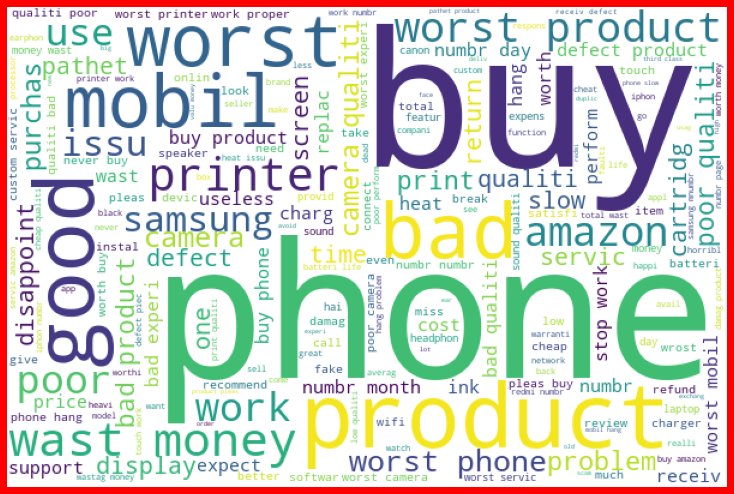

In [155]:
#Getting sense of words in Rating 1
one = df['Reviews'][df['Ratings']==1]

one_cloud = WordCloud(width=600,height=400,background_color='white',max_words=200).generate(' '.join(one))  #what is one in it??

plt.figure(figsize=(10,8),facecolor='r')
plt.imshow(one_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

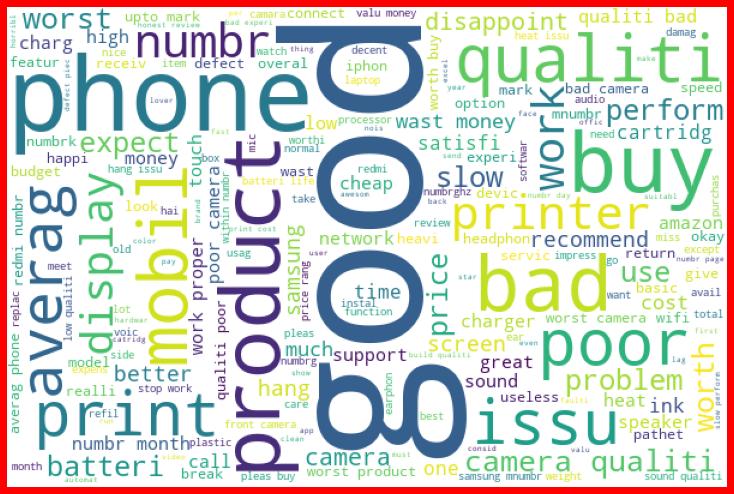

In [156]:
#Getting sense of words in Rating 2
one = df['Reviews'][df['Ratings']==2]

one_cloud = WordCloud(width=600,height=400,background_color='white',max_words=200).generate(' '.join(one))

plt.figure(figsize=(10,8),facecolor='r')
plt.imshow(one_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

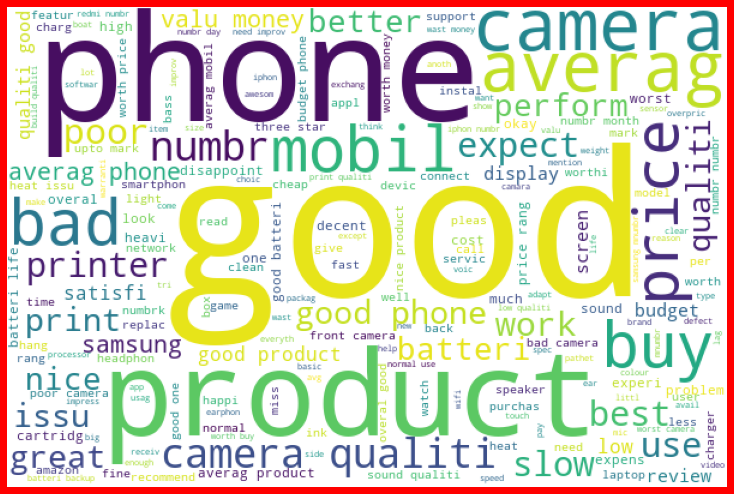

In [157]:
#Getting sense of words in Rating 3
one = df['Reviews'][df['Ratings']==3]

one_cloud = WordCloud(width=600,height=400,background_color='white',max_words=200).generate(' '.join(one))

plt.figure(figsize=(10,8),facecolor='r')
plt.imshow(one_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

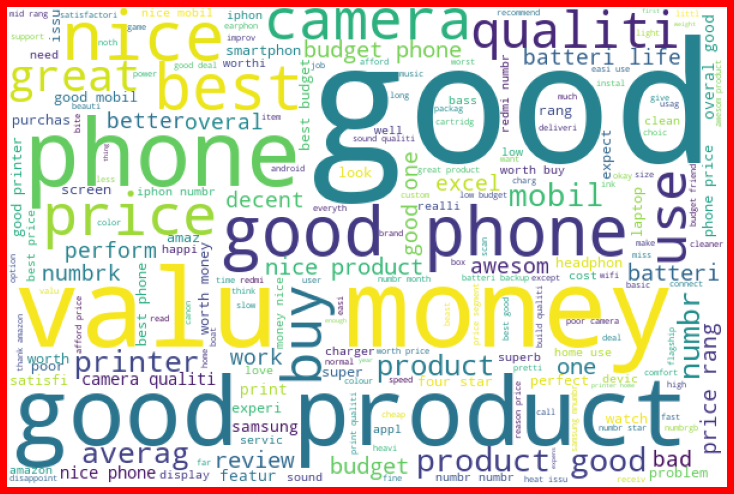

In [158]:
#Getting sense of words in Rating 4
one = df['Reviews'][df['Ratings']==4]

one_cloud = WordCloud(width=600,height=400,background_color='white',max_words=200).generate(' '.join(one))

plt.figure(figsize=(10,8),facecolor='r')
plt.imshow(one_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

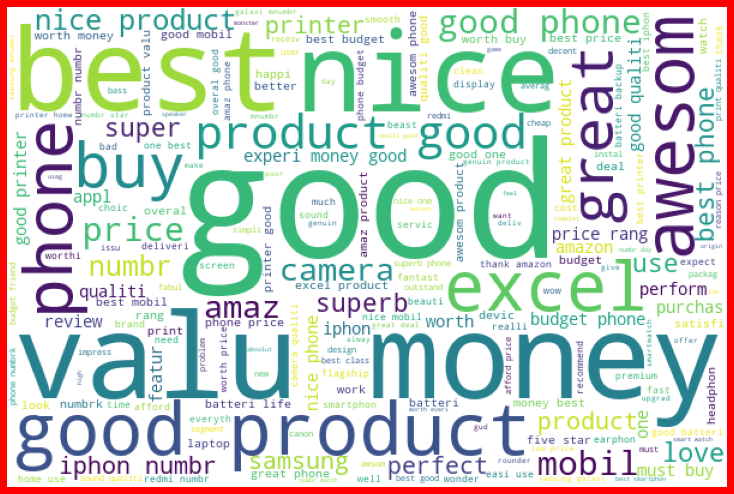

In [159]:
#Getting sense of words in Rating 5
one = df['Reviews'][df['Ratings']==5]

one_cloud = WordCloud(width=600,height=400,background_color='white',max_words=200).generate(' '.join(one))

plt.figure(figsize=(10,8),facecolor='r')
plt.imshow(one_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [160]:
#Converting text into numeric using TfidfVectorizer
#create object
tf = TfidfVectorizer()

#fitting 
features = tf.fit_transform(df['Reviews'])
x=features
y=df[['Ratings']]

In [161]:
x.shape

(38438, 4591)

In [162]:
y.shape

(38438, 1)

Model building

In [109]:
#Importing train_test_split, Logistic Regression and accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [110]:
def max_acc_score(reg,x,y):
    max_score=0
    for r_state in range (42,101):
        x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=r_state,test_size=0.20)
        reg.fit(x_train,y_train)
        pred=reg.predict(x_test)
        acc_score=accuracy_score(y_test,pred)
        print("The accuracy score at r_state", r_state, "is", acc_score)
        if acc_score>max_score:
            max_score=acc_score
            final_r_state=r_state
    print("The maximum accuracy score", max_score, "is achieved at", final_r_state)
    return max_score

In [111]:
LR=LogisticRegression()
max_acc_score(LR,x,y)

The accuracy score at r_state 42 is 0.5879292403746098
The accuracy score at r_state 43 is 0.5928720083246618
The accuracy score at r_state 44 is 0.592741935483871
The accuracy score at r_state 45 is 0.573621227887617
The accuracy score at r_state 46 is 0.5715400624349636
The accuracy score at r_state 47 is 0.5867585848074922
The accuracy score at r_state 48 is 0.5853277835587929
The accuracy score at r_state 49 is 0.5943028095733611
The accuracy score at r_state 50 is 0.586888657648283
The accuracy score at r_state 51 is 0.584417273673257
The accuracy score at r_state 52 is 0.581165452653486
The accuracy score at r_state 53 is 0.5780437044745057
The accuracy score at r_state 54 is 0.5838969823100937
The accuracy score at r_state 55 is 0.5857180020811654
The accuracy score at r_state 56 is 0.5759625390218522
The accuracy score at r_state 57 is 0.5889698231009365
The accuracy score at r_state 58 is 0.5877991675338189
The accuracy score at r_state 59 is 0.5828563995837669
The accuracy sc

0.5954734651404787

In [112]:
#Creating train_test_split using best random_state
x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=76,test_size=.20)

Finding out the best model

In [113]:
#Importing various classification models for testing
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [114]:
#Initializing the instance of the model
LR=LogisticRegression()
mnb=MultinomialNB()
dtc=DecisionTreeClassifier()
knc=KNeighborsClassifier()
rfc=RandomForestClassifier()
abc=AdaBoostClassifier()
gbc=GradientBoostingClassifier()

In [115]:
models= []
models.append(('Logistic Regression',LR))
models.append(('MultinomialNB',mnb))
models.append(('DecisionTreeClassifier',dtc))
models.append(('KNeighborsClassifier',knc))
models.append(('RandomForestClassifier',rfc))
models.append(('AdaBoostClassifier',abc))
models.append(('GradientBoostingClassifier',gbc))

In [116]:
#Importing required modules and metrices
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import cross_val_score

In [117]:
#Making a for loop and calling the algorithm one by one and save data to respective model using append function
Model=[]
score=[]
cvs=[]
rocscore=[]
for name,model in models:
    print('******************************',name,'***************************')
    print('\n')
    Model.append(name)
    model.fit(x_train,y_train)
    print(model)
    pre=model.predict(x_test)
    print('\n')
    AS=accuracy_score(y_test,pre)
    print('accuracy_score: ',AS)
    score.append(AS*100)
    print('\n')
    sc=cross_val_score(model,x,y,cv=5,scoring='accuracy').mean()
    print('cross_val_score: ',sc)
    cvs.append(sc*100)
    print('\n')
    print('Classification report:\n ')
    print(classification_report(y_test,pre))
    print('\n')
    print('Confusion matrix: \n')
    cm=confusion_matrix(y_test,pre)
    print(cm)
    print('\n\n\n')

****************************** Logistic Regression ***************************


LogisticRegression()


accuracy_score:  0.5816857440166493


cross_val_score:  0.5766155496928678


Classification report:
 
              precision    recall  f1-score   support

           1       0.64      0.75      0.69      1695
           2       0.30      0.02      0.04       438
           3       0.37      0.18      0.25       870
           4       0.42      0.15      0.22      1544
           5       0.60      0.89      0.72      3141

    accuracy                           0.58      7688
   macro avg       0.46      0.40      0.38      7688
weighted avg       0.53      0.58      0.52      7688



Confusion matrix: 

[[1277    3   62   58  295]
 [ 203    9   62   28  136]
 [ 221    7  160  117  365]
 [ 151    7   85  236 1065]
 [ 159    4   59  129 2790]]




****************************** MultinomialNB ***************************


MultinomialNB()


accuracy_score:  0.570369406867846


cross_va

In [118]:
#Finalizing the result
result=pd.DataFrame({'Model':Model, 'Accuracy_score': score,'Cross_val_score':cvs})
result

,Model,Accuracy_score,Cross_val_score
0,Logistic Regression,58.168574,57.661555
1,MultinomialNB,57.036941,57.180289
2,DecisionTreeClassifier,62.135796,62.133414
3,KNeighborsClassifier,50.845473,49.549740
4,RandomForestClassifier,64.776275,64.063815
5,AdaBoostClassifier,52.705515,52.856462
6,GradientBoostingClassifier,54.552549,54.456433


Hyperparameter Tuning

In [119]:
#RandomForestClassifier
parameters={'n_estimators':[1,10,100]}

In [120]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
rfc=RandomForestClassifier(random_state=76)   #Using the best random state we obtained
rfc=GridSearchCV(rfc,parameters,cv=3,scoring='accuracy')
rfc.fit(x_train,y_train)
print(rfc.best_params_)     #Printing the best parameters obtained
print(rfc.best_score_)      #Mean cross-validated score of best_estimator

{'n_estimators': 100}
0.6135609756097561


In [121]:
#Using the best parameters obtained
rfc=RandomForestClassifier(random_state=76,n_estimators=100)
rfc.fit(x_train,y_train)
pred=rfc.predict(x_test)
print("Accuracy score: ",accuracy_score(y_test,pred)*100)
print('Cross validation score: ',cross_val_score(rfc,x,y,cv=3,scoring='accuracy').mean()*100)
print('Classification report: \n')
print(classification_report(y_test,pred))
print('Confusion matrix: \n')
print(confusion_matrix(y_test,pred))

Accuracy score:  64.82830385015609
Cross validation score:  63.07274322197078
Classification report: 

              precision    recall  f1-score   support

           1       0.71      0.76      0.73      1695
           2       0.60      0.31      0.41       438
           3       0.64      0.39      0.48       870
           4       0.56      0.31      0.40      1544
           5       0.64      0.87      0.74      3141

    accuracy                           0.65      7688
   macro avg       0.63      0.53      0.55      7688
weighted avg       0.64      0.65      0.62      7688

Confusion matrix: 

[[1288   27   54   60  266]
 [ 132  135   33   28  110]
 [ 157   21  336   90  266]
 [ 107   16   61  478  882]
 [ 132   25   43  194 2747]]


In [122]:
#GradientBoostingClassifier
parameters={'n_estimators':[1,10,100]}

In [123]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
gbc=GradientBoostingClassifier(random_state=76)   #Using the best random state we obtained
gbc=GridSearchCV(gbc,parameters,cv=3,scoring='accuracy')
gbc.fit(x_train,y_train)
print(gbc.best_params_)     #Printing the best parameters obtained
print(gbc.best_score_)      #Mean cross-validated score of best_estimator

{'n_estimators': 100}
0.5452682926829269


In [124]:
#Using the best parameters obtained
gbc=GradientBoostingClassifier(random_state=76,n_estimators=100)
gbc.fit(x_train,y_train)
pred=gbc.predict(x_test)
print("Accuracy score: ",accuracy_score(y_test,pred)*100)
print('Cross validation score: ',cross_val_score(gbc,x,y,cv=3,scoring='accuracy').mean()*100)
print('Classification report: \n')
print(classification_report(y_test,pred))
print('Confusion matrix: \n')
print(confusion_matrix(y_test,pred))

Accuracy score:  54.487513007284086
Cross validation score:  54.18070630975764
Classification report: 

              precision    recall  f1-score   support

           1       0.68      0.58      0.62      1695
           2       0.76      0.03      0.06       438
           3       0.58      0.12      0.20       870
           4       0.47      0.11      0.17      1544
           5       0.51      0.93      0.66      3141

    accuracy                           0.54      7688
   macro avg       0.60      0.35      0.34      7688
weighted avg       0.56      0.54      0.47      7688

Confusion matrix: 

[[ 975    2   17   15  686]
 [ 141   13   21   15  248]
 [ 144    1  106   48  571]
 [  81    1   31  164 1267]
 [  92    0    8  110 2931]]


In [125]:
rfc_prediction=rfc.predict(x)

#Making a dataframe of predictions
rating_prediction=pd.DataFrame({'Predictions':rfc_prediction})
rating_prediction

,Predictions
0,1
1,1
2,5
3,1
4,5
...,...
38433,5
38434,5
38435,5
38436,5


In [126]:
#Saving the model
import pickle
filename='RatingsPrediction_Project.pkl'   #Specifying the filename
pickle.dump(rfc,open(filename,'wb'))

In [127]:
#Saving predicted values
rating_prediction.to_csv('RatingsPrediction_DataResults.csv')